In [1]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
plt.rcParams["axes.grid"] = False

In [2]:
# define the number of samples to be drawn
n_samples = 100

In [3]:
# define the mean points for each of the systhetic cluster centers
t_means = [[8.4, 8.2], [1.4, 1.6], [2.4, 5.4], [6.4, 2.4]]

# for each cluster center, create a Positive semidefinite convariance matrix
t_covs = []
for s in range(len(t_means)):
  t_covs.append(make_spd_matrix(2))

X = []
for mean, cov in zip(t_means,t_covs):
  x = np.random.multivariate_normal(mean, cov, n_samples)
  X += list(x)

X = np.array(X)
np.random.shuffle(X)
print("Dataset shape:", X.shape)

Dataset shape: (400, 2)


In [4]:
# Create a grid for visualization purposes
x = np.linspace(np.min(X[...,0])-1,np.max(X[...,0])+1,100)
y = np.linspace(np.min(X[...,1])-1,np.max(X[...,1])+1,80)
X_,Y_ = np.meshgrid(x,y)
pos = np.array([X_.flatten(),Y_.flatten()]).T
print(pos.shape)
print(np.max(pos[...,1]))

(8000, 2)
10.996758203447879


In [5]:
# define the number of clusters to be learned
k = 4

# create and initialize the cluster centers and the weight paramters
weights = np.ones((k)) / k
means = np.random.choice(X.flatten(), (k,X.shape[1]))
print(means)
print(weights)

[[ 7.37219839  5.32366375]
 [11.60216425 10.32937486]
 [ 2.51350867  2.60656084]
 [ 2.32132189  2.58779644]]
[0.25 0.25 0.25 0.25]


In [6]:
# create and initialize a Positive semidefinite convariance matrix
cov = []
for i in range(k):
  cov.append(make_spd_matrix(X.shape[1]))
cov = np.array(cov)
print(cov.shape)

(4, 2, 2)


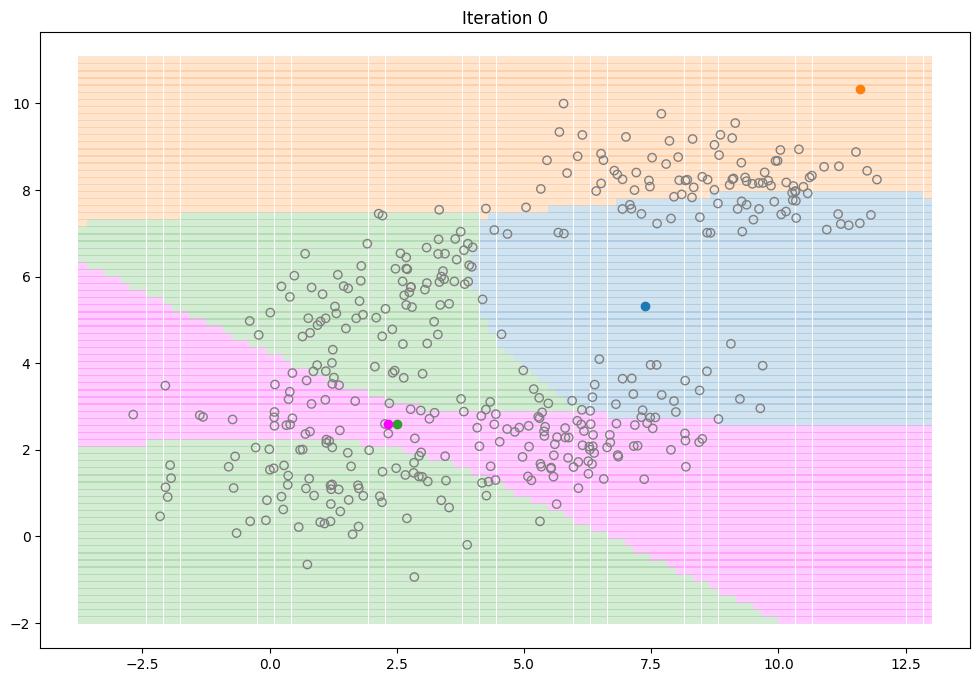

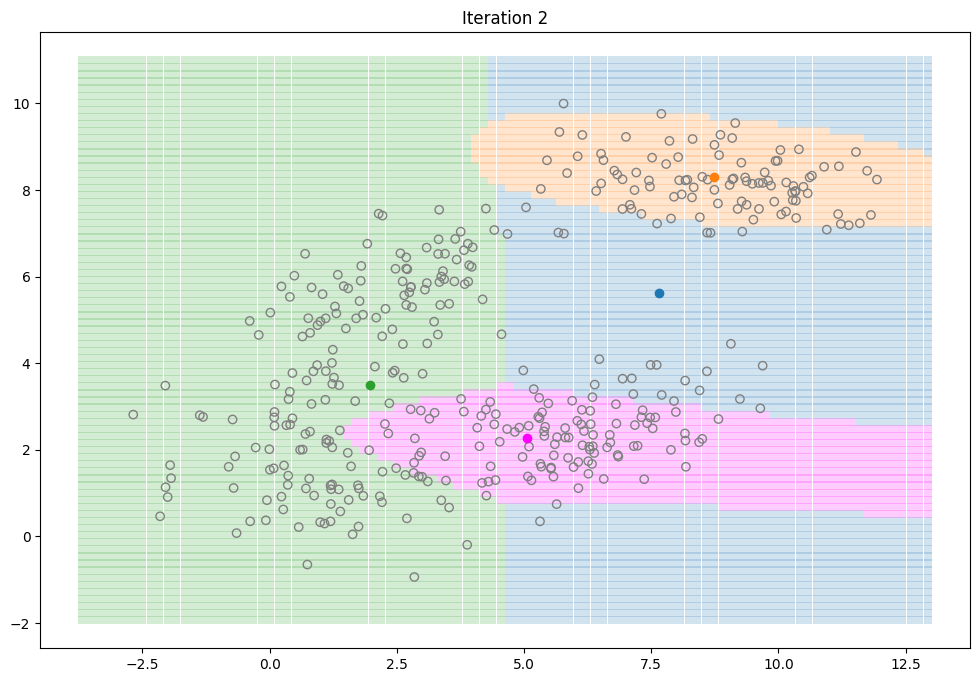

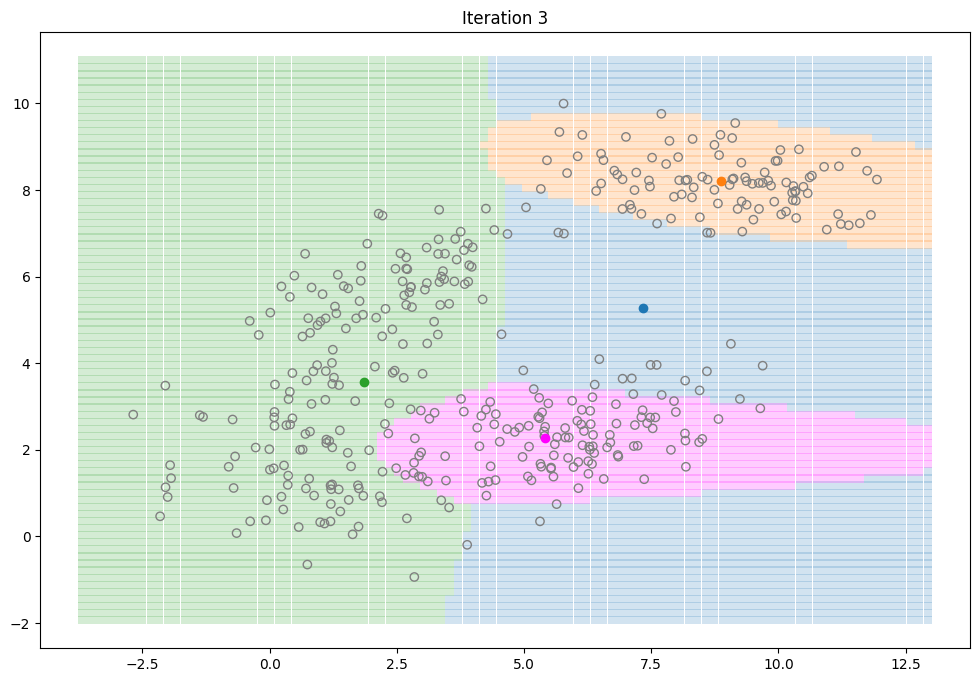

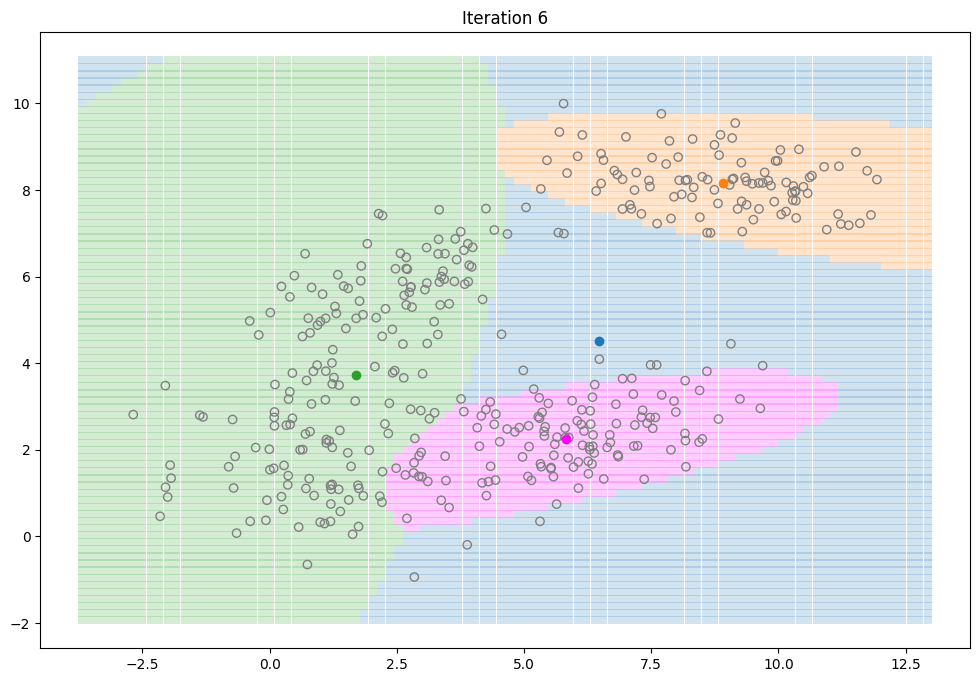

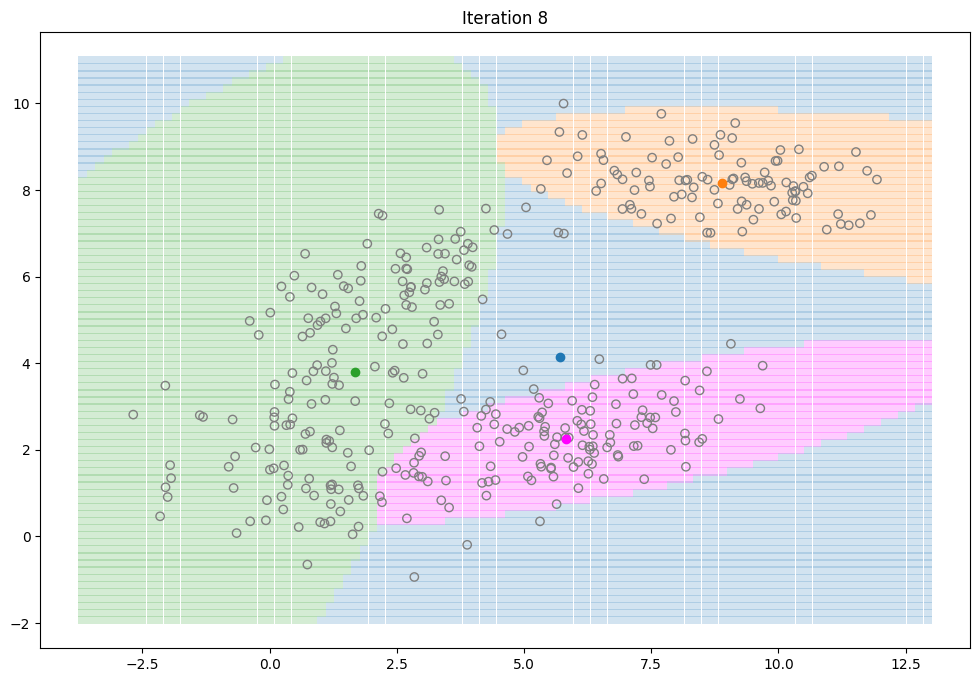

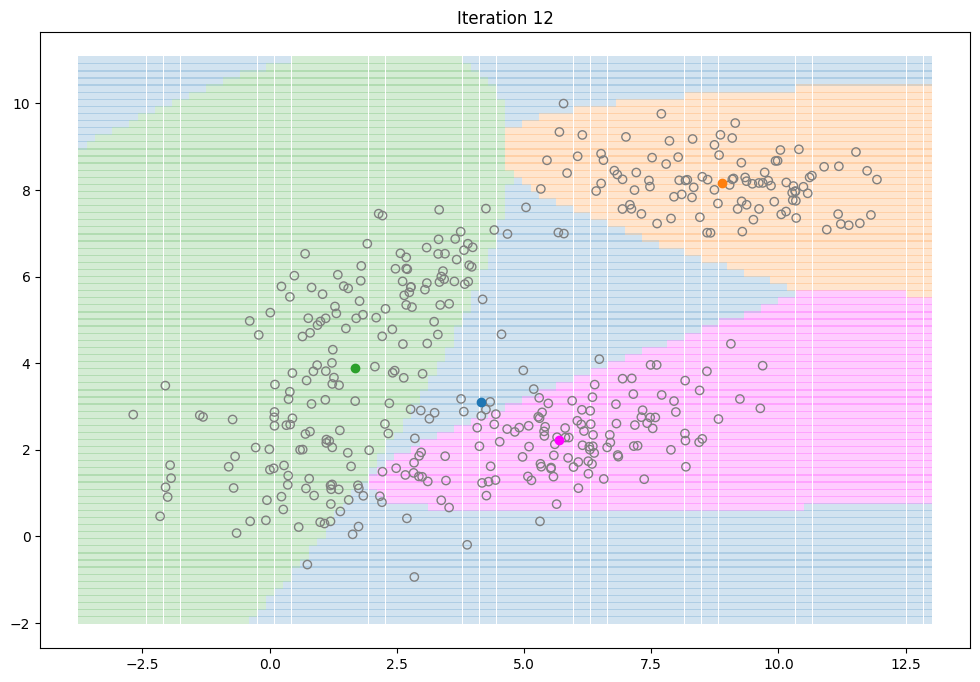

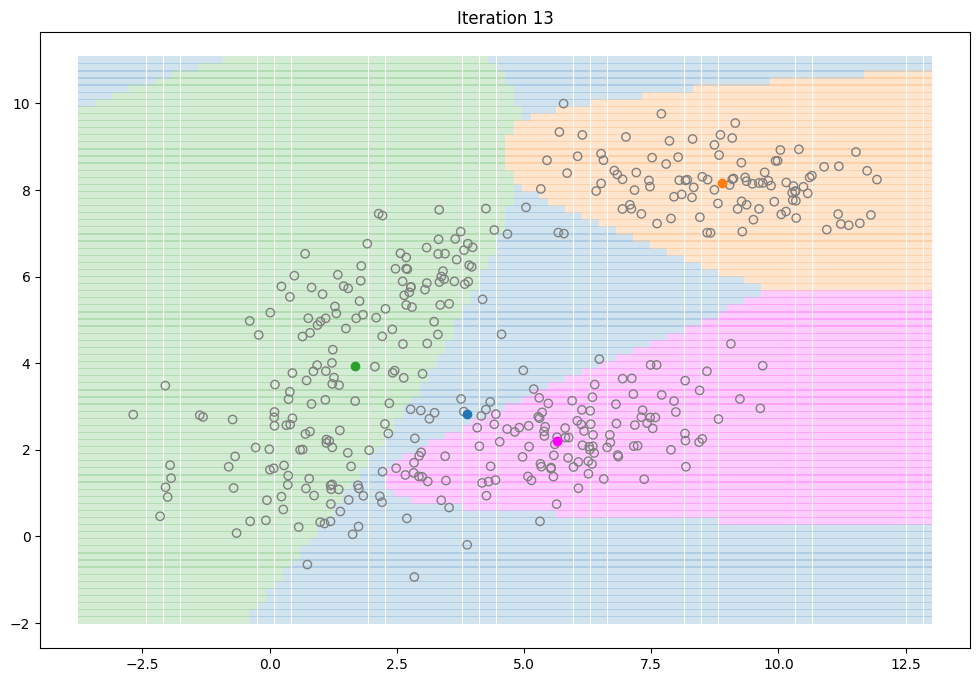

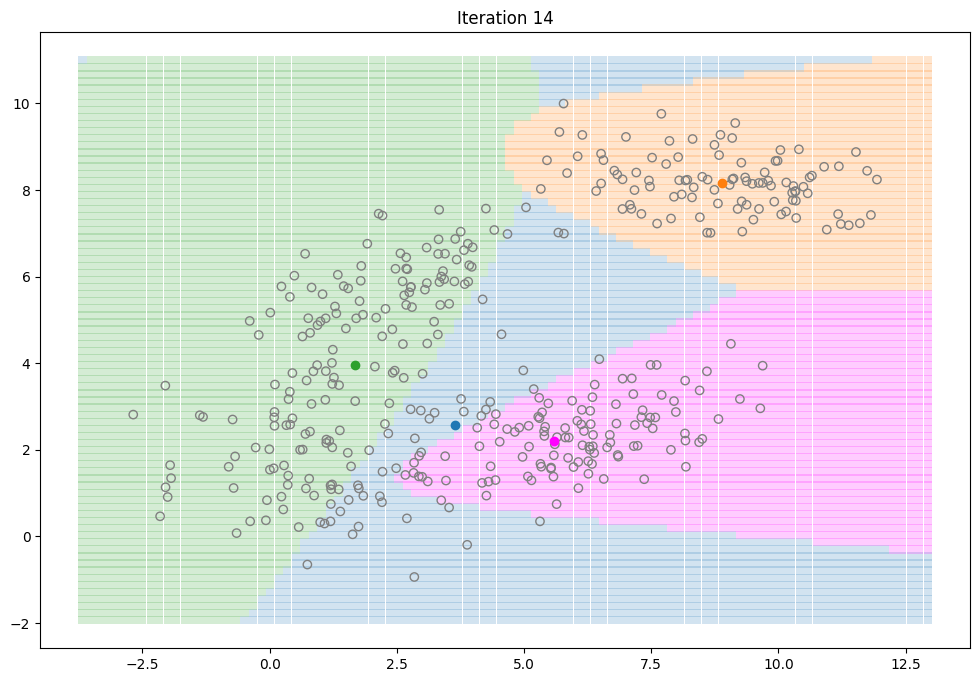

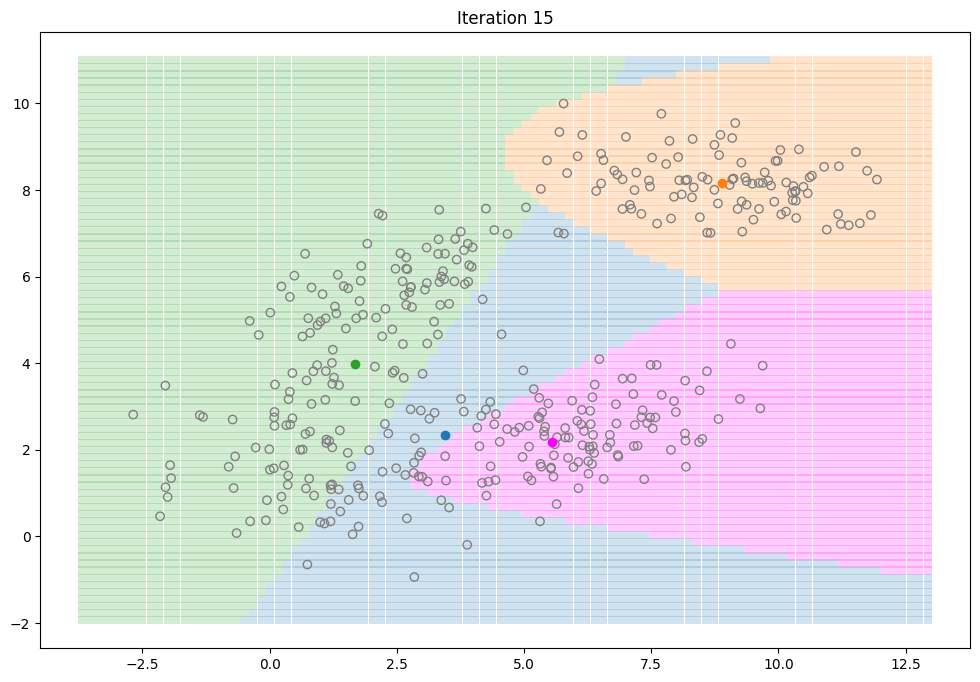

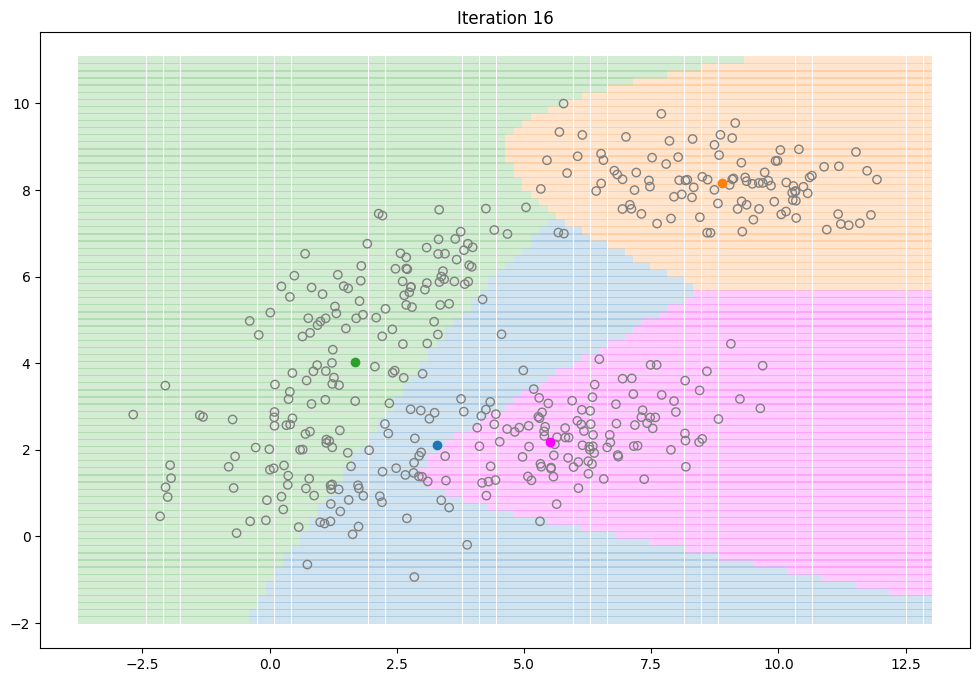

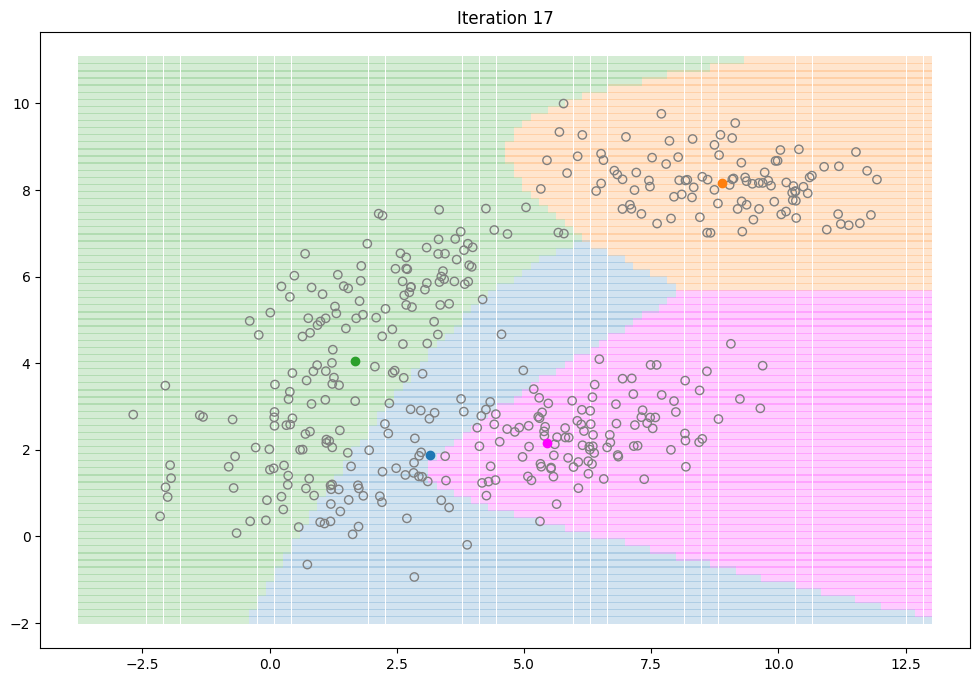

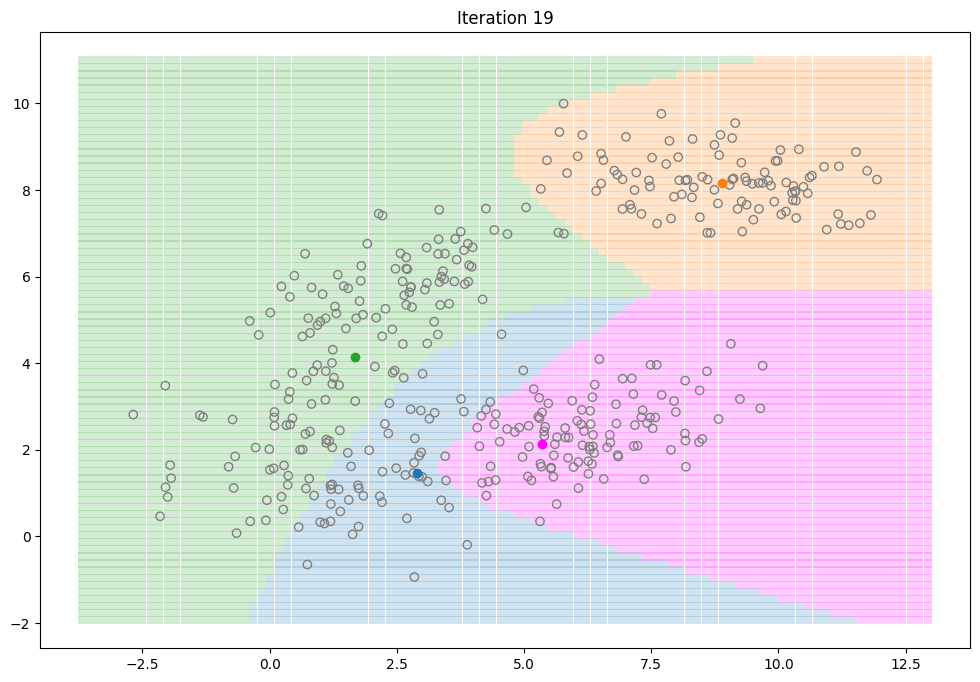

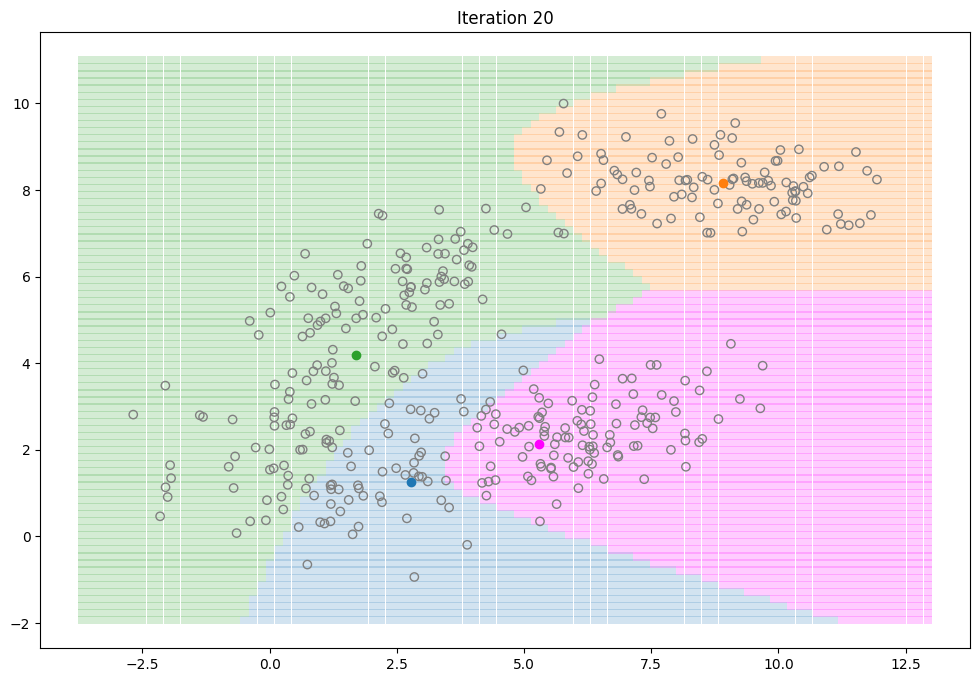

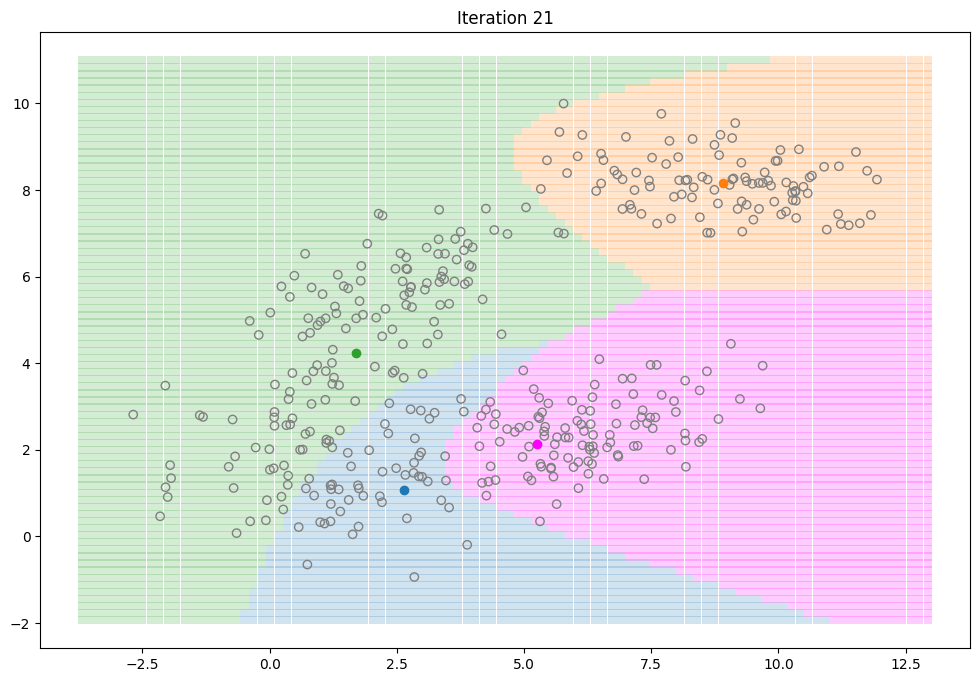

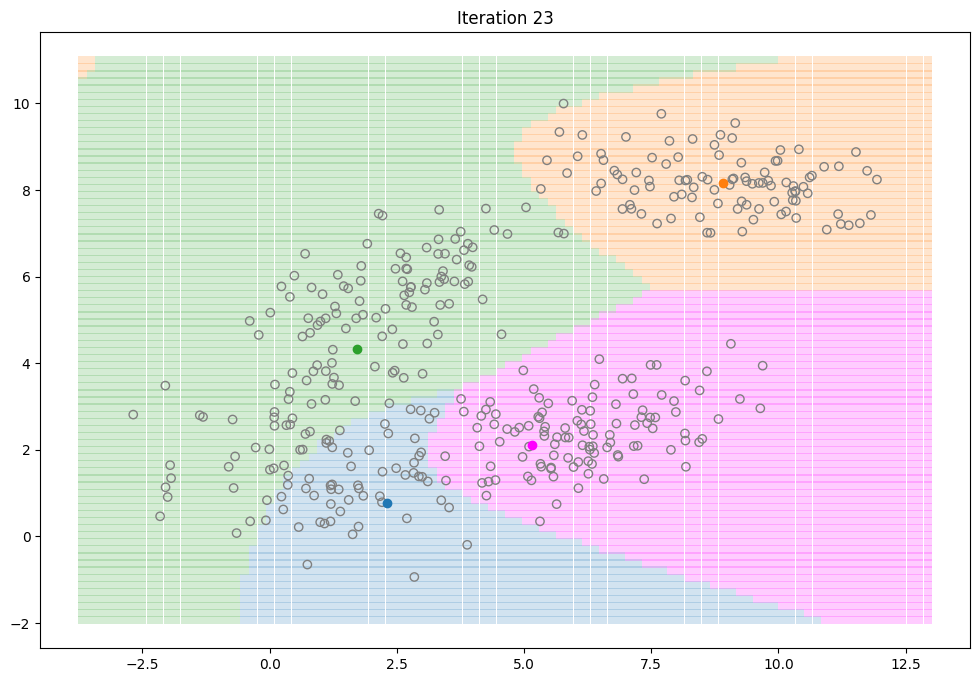

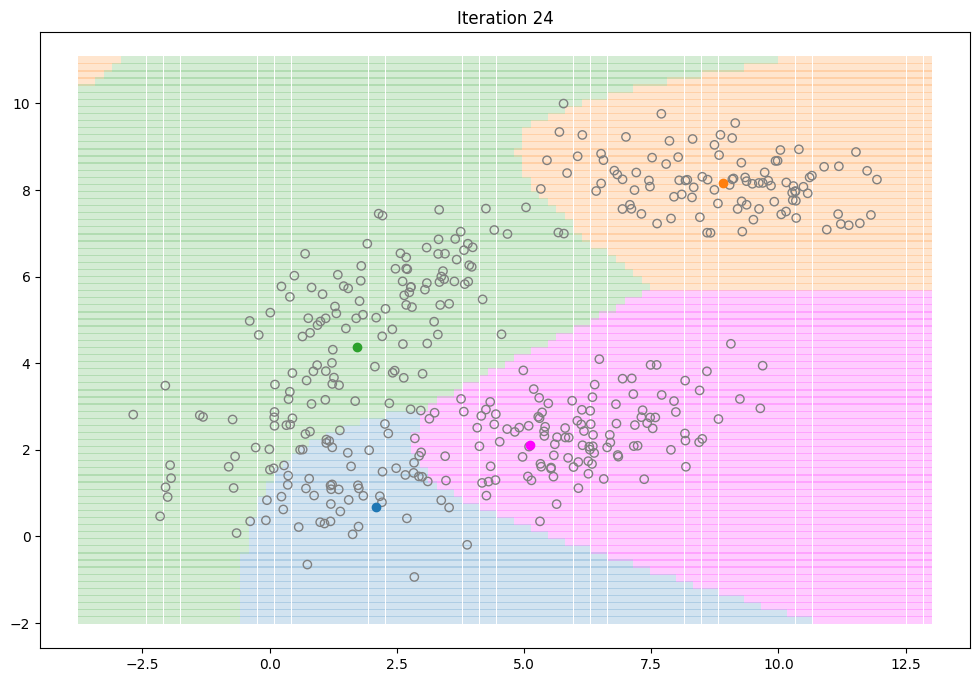

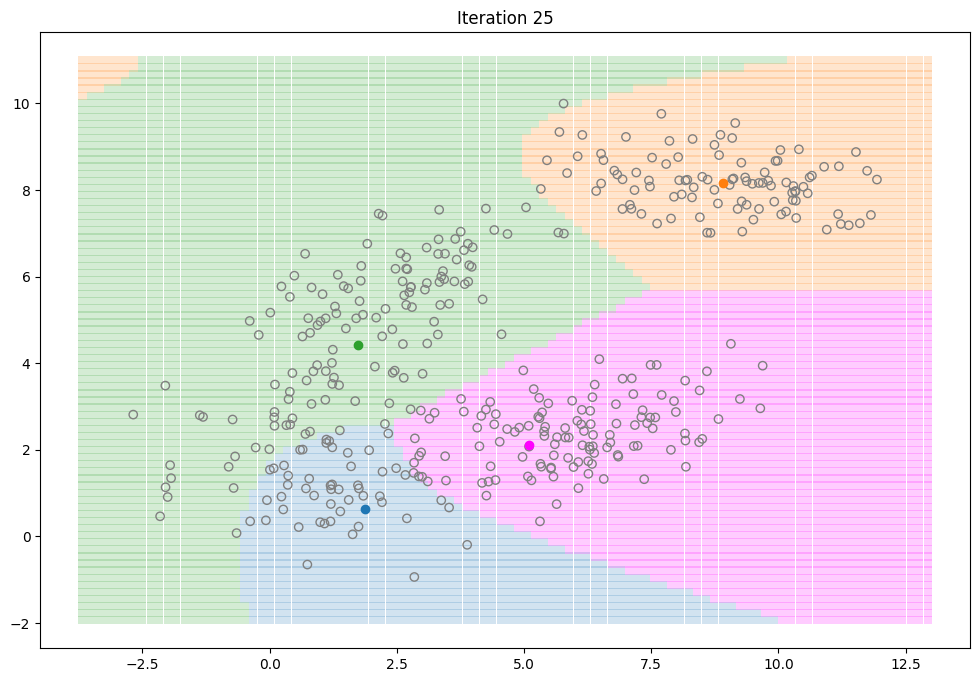

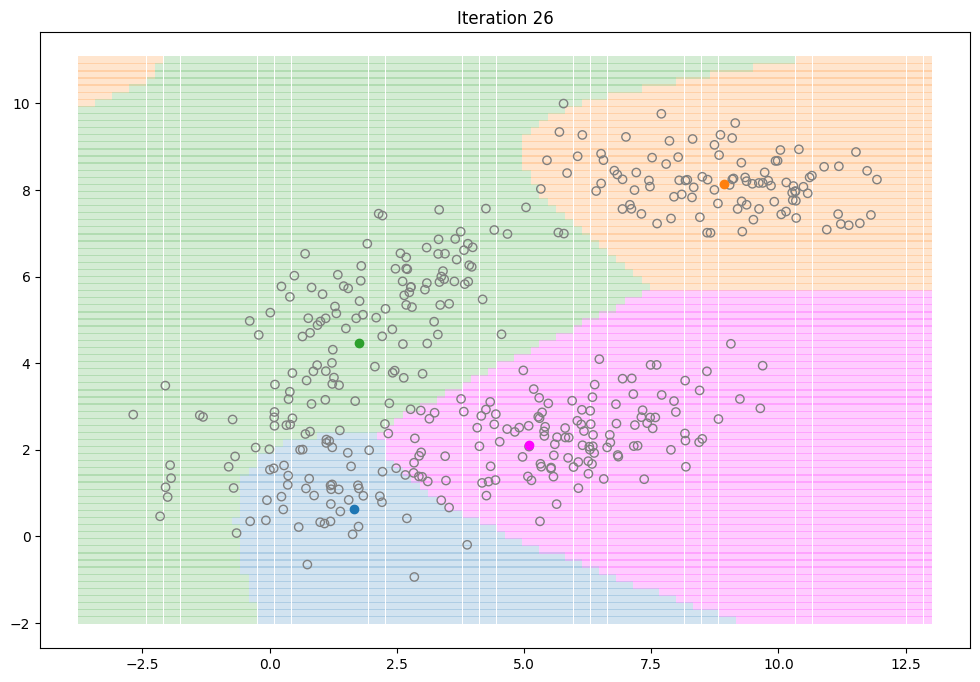

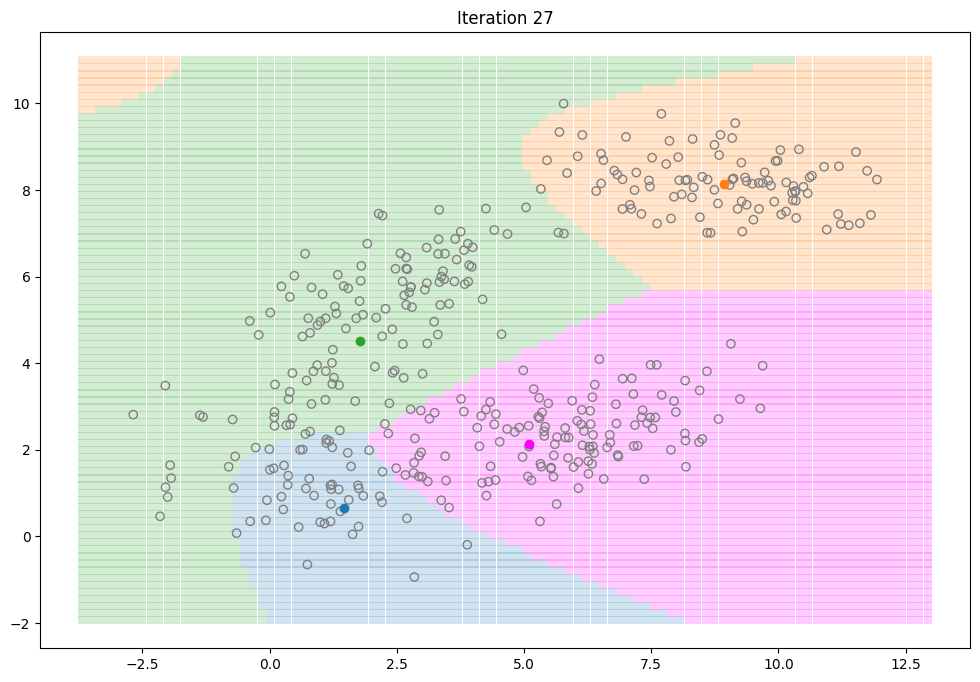

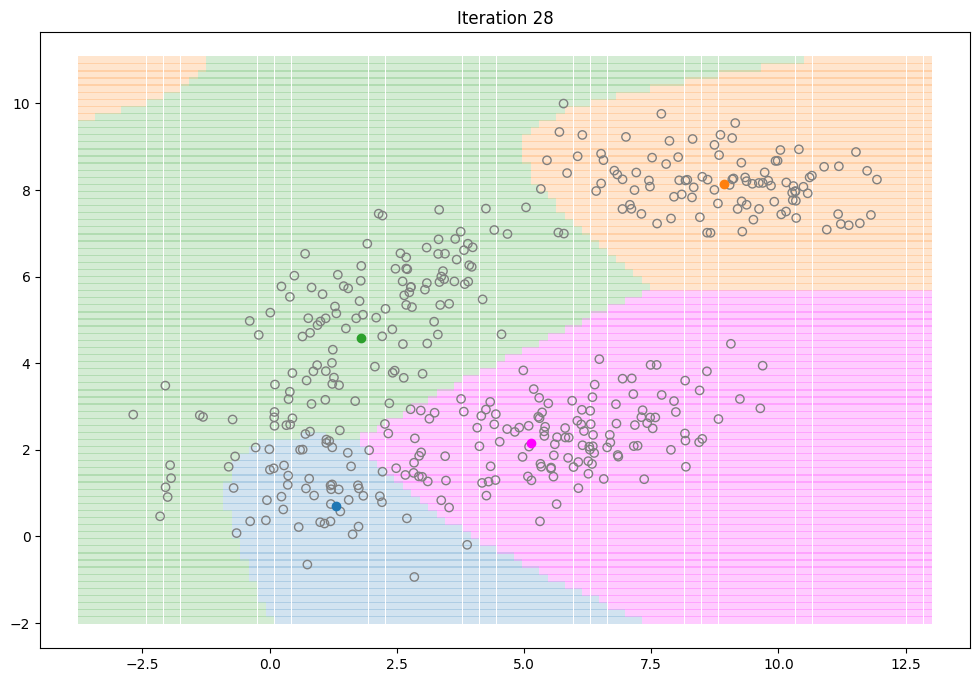

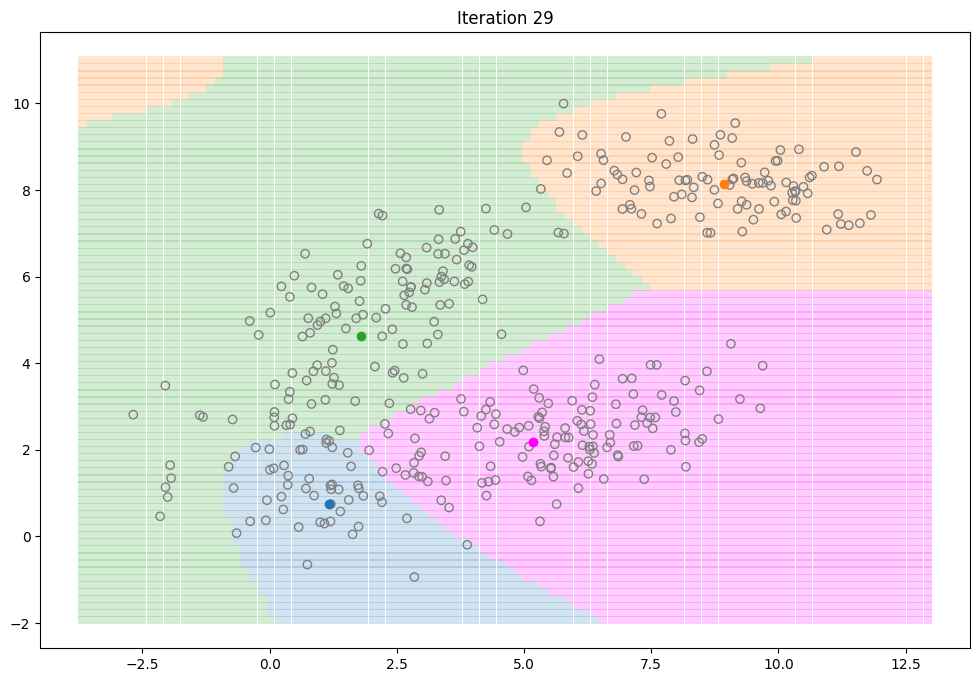

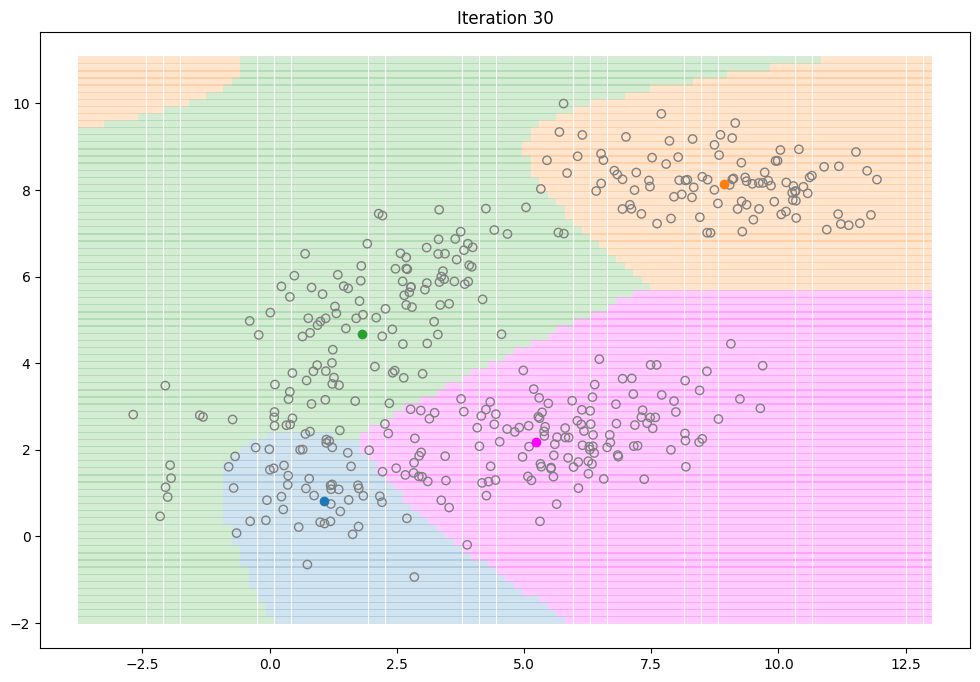

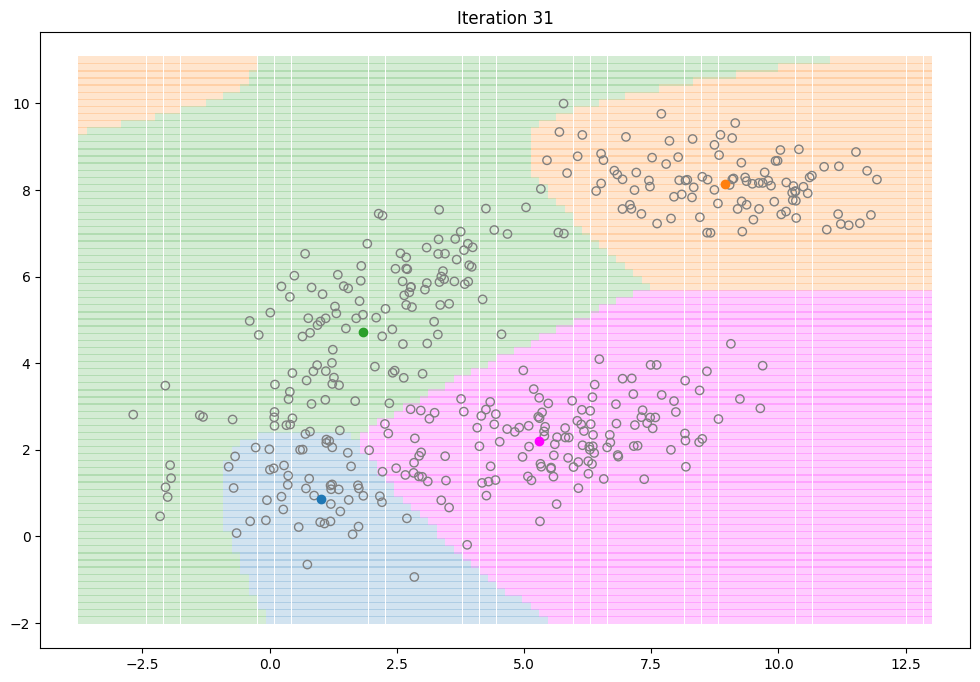

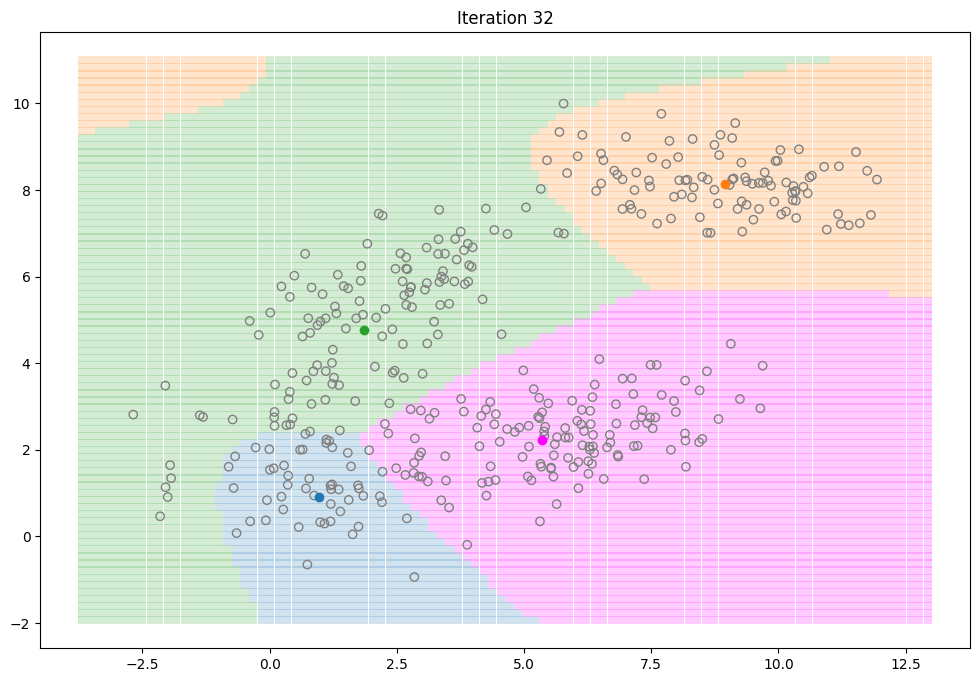

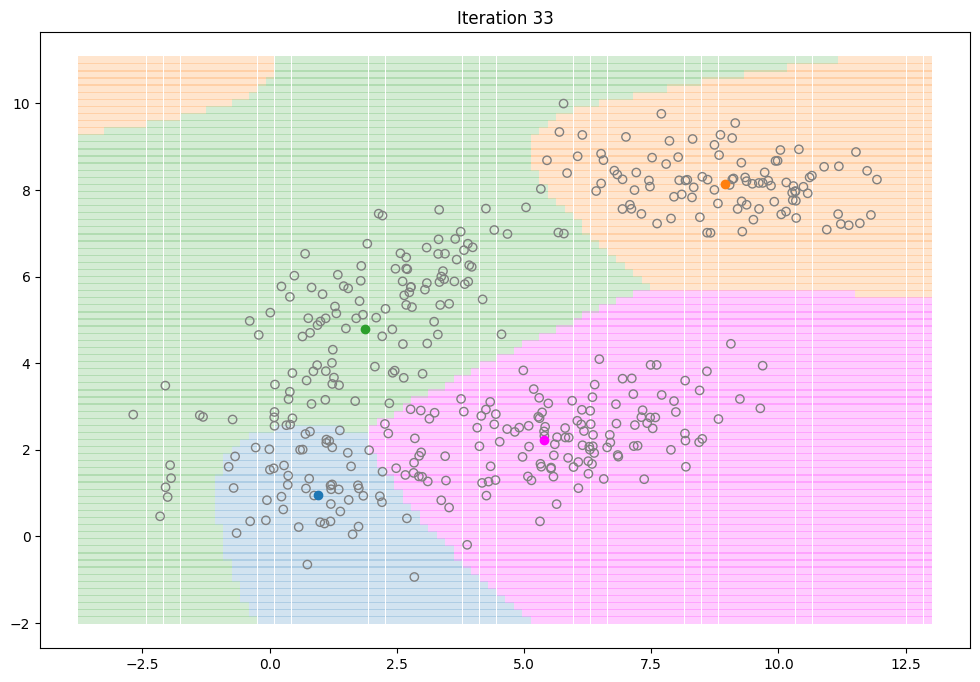

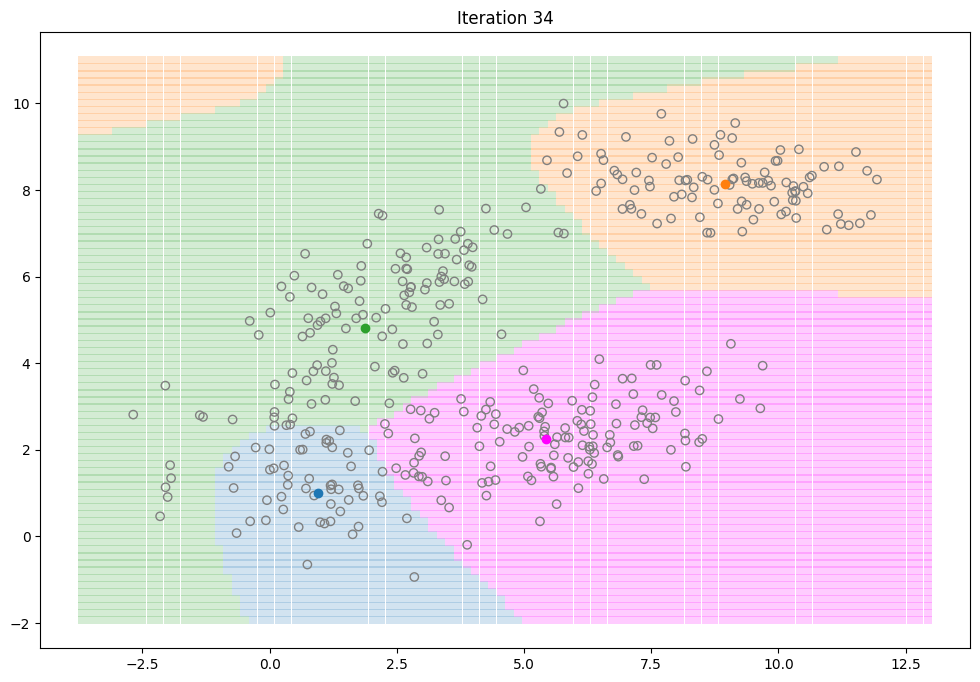

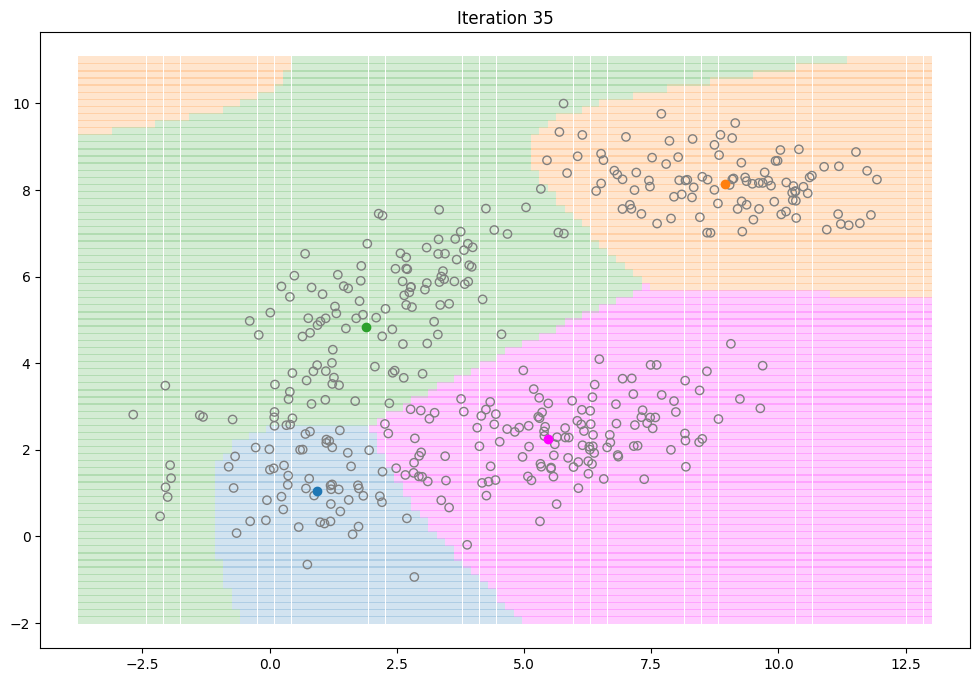

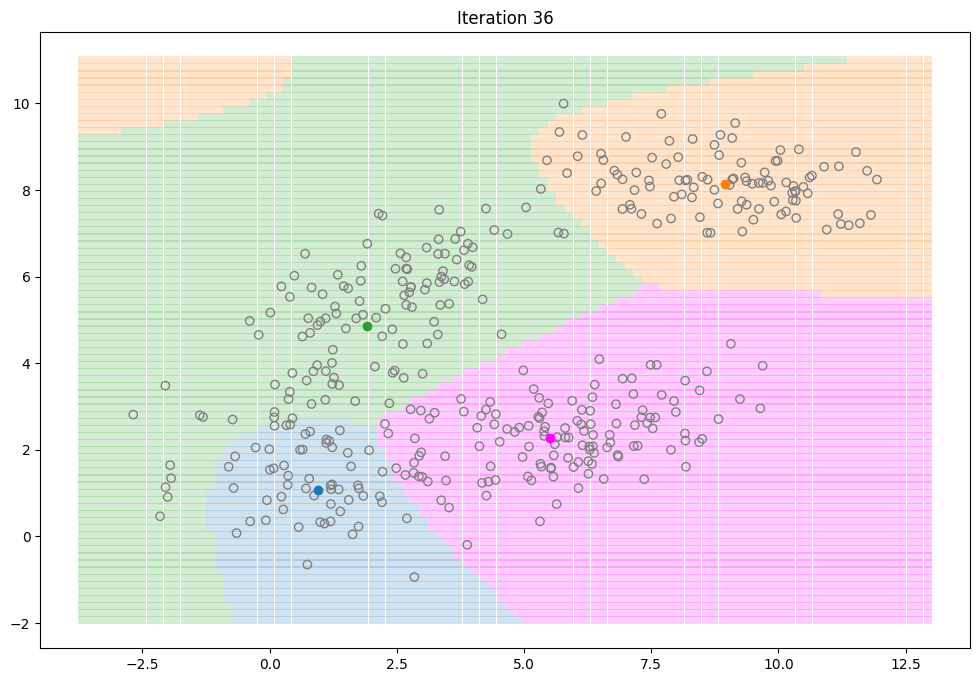

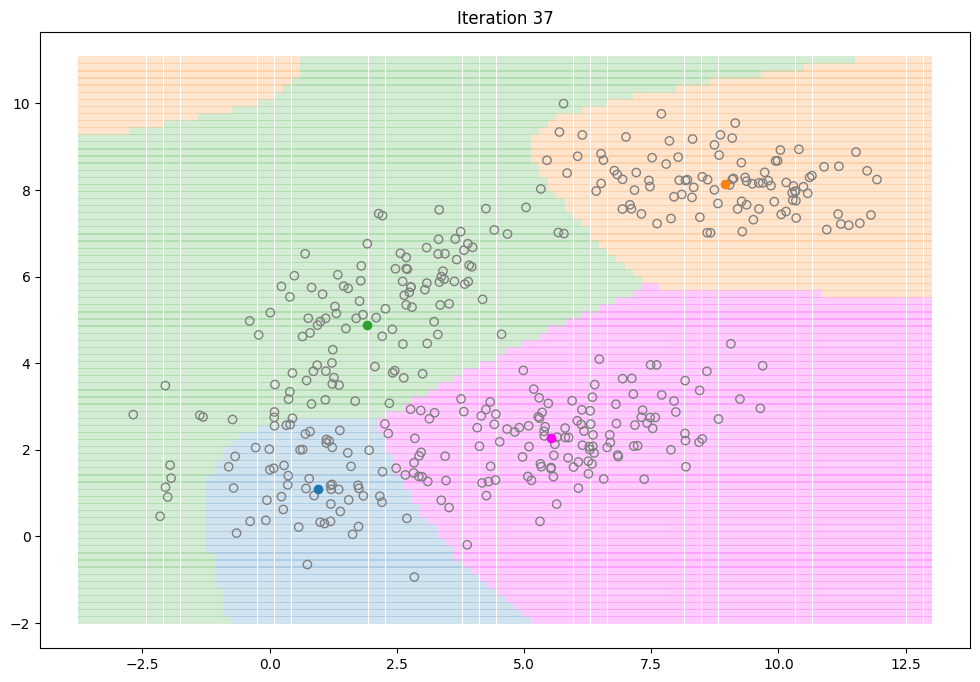

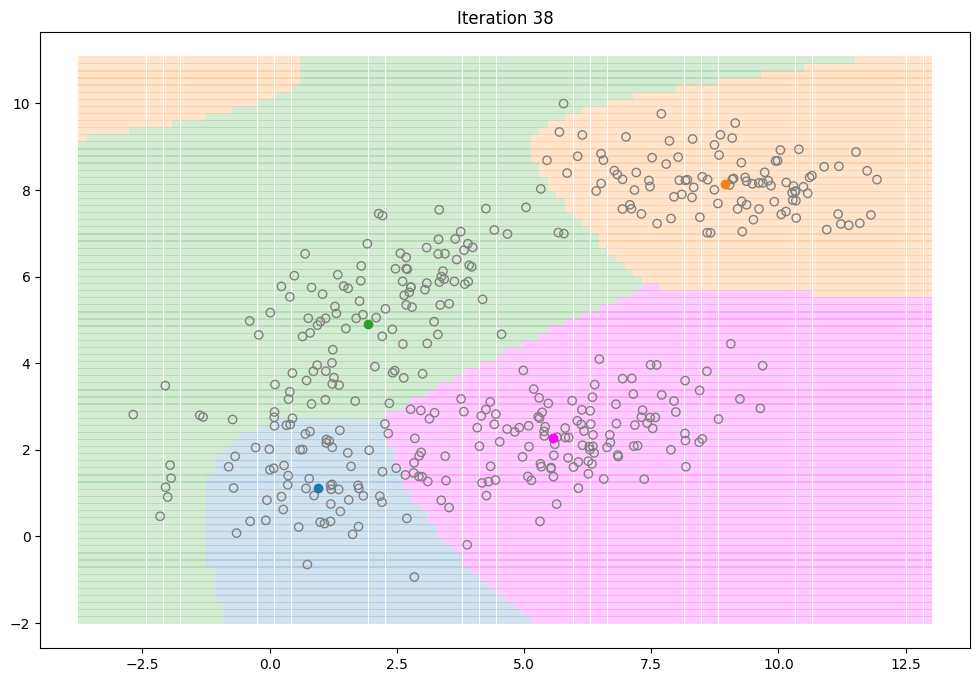

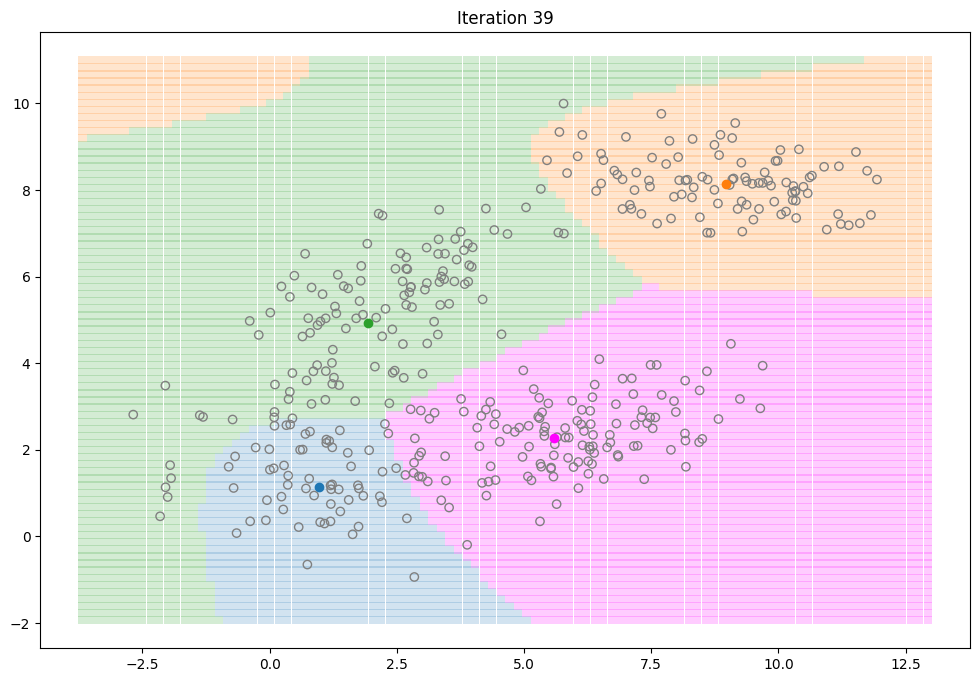

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'magenta', 'yellow', 'red', 'brown', 'grey']
eps=1e-8

# run GMM for 40 steps
for step in range(40):

  # visualize the learned clusters
  if step % 1 == 0:
    plt.figure(figsize=(12,int(8)))
    plt.title("Iteration {}".format(step))
    axes = plt.gca()

    likelihood = []
    for j in range(k):
      likelihood.append(multivariate_normal.pdf(x=pos, mean=means[j], cov=cov[j]))
    likelihood = np.array(likelihood)
    predictions = np.argmax(likelihood, axis=0)

    for c in range(k):
      pred_ids = np.where(predictions == c)
      plt.scatter(pos[pred_ids[0],0], pos[pred_ids[0],1], color=colors[c], alpha=0.2, edgecolors='none', marker='s')

    plt.scatter(X[...,0], X[...,1], facecolors='none', edgecolors='grey')

    for j in range(k):
      plt.scatter(means[j][0], means[j][1], color=colors[j])

    #plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
    plt.show()

  likelihood = []
  # Expectation step
  for j in range(k):
    likelihood.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]))
  likelihood = np.array(likelihood)
  assert likelihood.shape == (k, len(X))

  b = []
  # Maximization step
  for j in range(k):
    # use the current values for the parameters to evaluate the posterior
    # probabilities of the data to have been generanted by each gaussian
    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))

    # updage mean and variance
    means[j] = np.sum(b[j].reshape(len(X),1) * X, axis=0) / (np.sum(b[j]+eps))
    cov[j] = np.dot((b[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(b[j])+eps)

    # update the weights
    weights[j] = np.mean(b[j])

    assert cov.shape == (k, X.shape[1], X.shape[1])
    assert means.shape == (k, X.shape[1])

In [8]:
# !sudo apt-get update
# !sudo apt-get install ffmpeg imagemagick
# !convert -delay 35 -loop 0 *.png out_.gif